## Employee Retention Prediction 

The objective of this project is to analyze a dataset and build predictive models that can provide insights about employees retention.
The two problems this project tries to solve are:
- how likely is an employee leaving the company?
- what factors most contribute to an emplyee leaving the company? 

The main goal of the the project is to build a machine learning model that predicts whether an employee leaves the company based on employees data from the past. The model will help the company by assisting what kind of employers are more likely to leave and what factors contribute to their leave or stay.This will help the company identify potential employees that are likely to leave,and devise plans to reatain them using different surveys which will help in further reducing the cost that is used to hire,and train new employees.

## Import Packges and data

In [459]:
# Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Dataset Extraction

The dataset for this project is found in [here.](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?resource=download)

In [519]:
data_1=pd.read_csv('HR_data.csv')
data_1.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Exploratory Data Analysis (EDA) and Data Cleaning

This is the stage where we begin with underdstanding of our data.

In [527]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   tenure                 14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [517]:
data_1['left'].value_counts(normalize=True)

0    0.761917
1    0.238083
Name: left, dtype: float64

76.2% of employees have been retained at the company.

#### Missing values

In [239]:
data_1.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

There seems to be no missing values in the dataset

#### Duplicates

In [521]:
len(data_1[data_1.duplicated()==True])

3008

There was a few over 3000 rows with duplicated entries. Duplicates need to be removed.

In [155]:
data_1.shape

(14999, 10)

In [156]:
data_1=data_1.drop_duplicates(keep='first')
data_1.shape

(11991, 10)

#### Outliers

We need to create a function to see if there are any outliers in the dataset and we also need to check how many outlier values are in the dataset

In [157]:
def outlier_imputer(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    
    lower_limit=q1-1.5*IQR
    upper_limit=q3+1.5*IQR
    outliers=df[(df<lower_limit)|(df>upper_limit)]
    return outliers
                                  

In [158]:
outliers_time_spend=outlier_imputer(data_1['time_spend_company'])
len(outliers_time_spend)

824

In [240]:
print('Number of outliers: ', len(outliers_time_spend))
print('Maximum value of outlier is: ', max(outliers_time_spend))
print('Minimum valie of outlier is: ', min(outliers_time_spend))

Number of outliers:  824
Maximum value of outlier is:  10
Minimum valie of outlier is:  6


#### Renaming Features

Naming features have to be consistent. some columns are wrongly named. we use 'snake_case' format

In [522]:
data_1.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [523]:
data_1=data_1.rename(columns=
    {
    'time_spend_company':'tenure',
    'average_montly_hours': 'average_monthly_hours',
    'Work_accident':'work_accident',
    'Department':'department'
    
    })

In [524]:
data_1.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

#### Visualizaton

Now let's examine variables that we are interested in, and create plots to visualize relationships between variables

Relationship between number of projects an employee is involved and whether they left the company or not

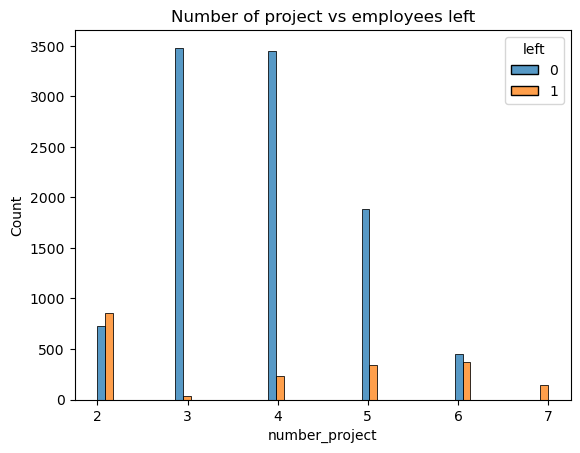

In [84]:
sns.histplot(data=data_1,x='number_project',hue='left',multiple='dodge')
plt.title('Number of project vs employees left')
plt.show()

The above figure shows those emploees who left have completed the most number of projects. Let's confirm it

In [525]:
data_1[data_1['number_project']==7]['left'].value_counts()

1    256
Name: left, dtype: int64

The above confirms all those employees who have been involved in 7 projects haave left the company.

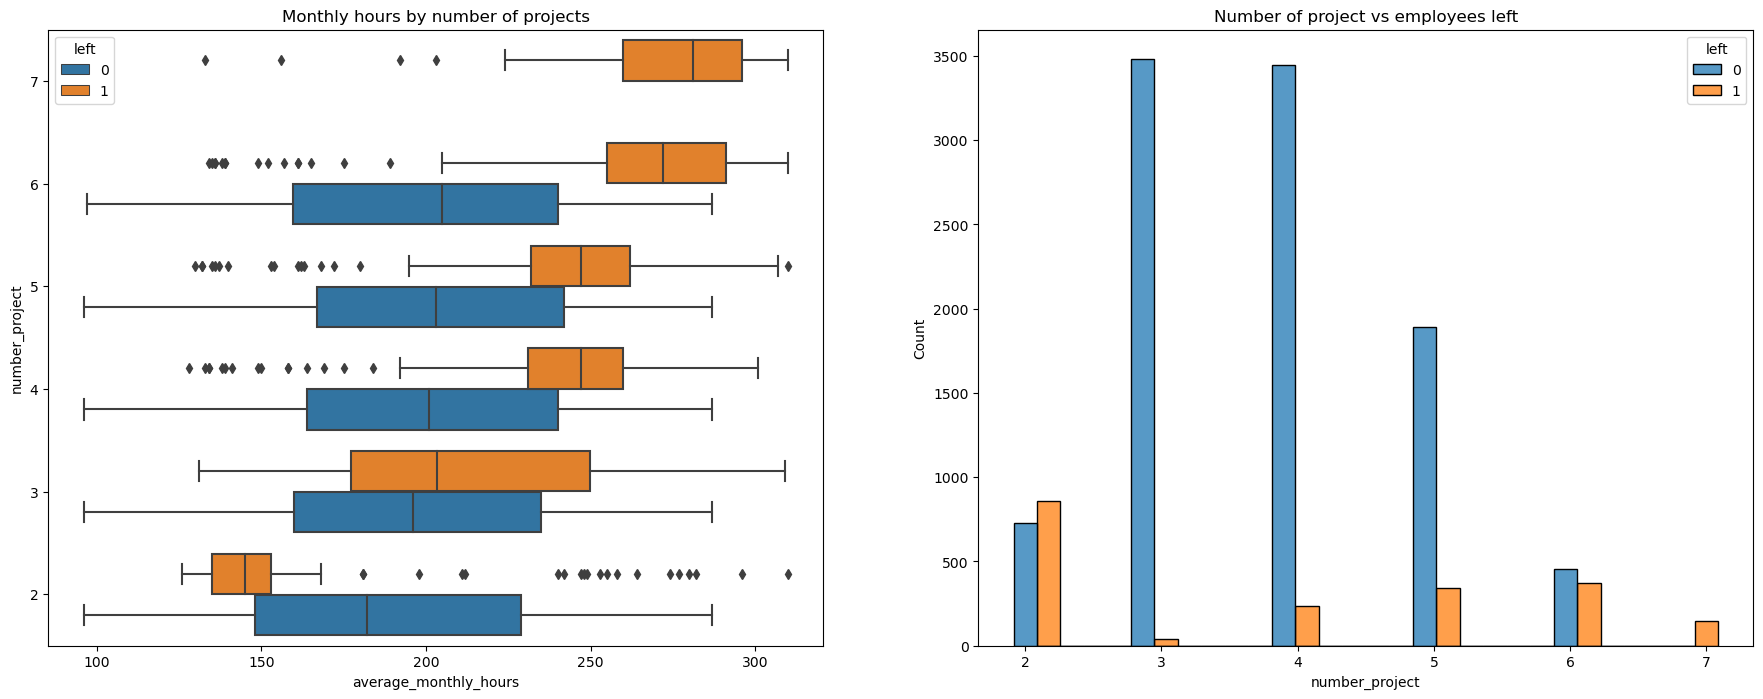

In [85]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

sns.boxplot(data=data_1, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects')

sns.histplot(data=data_1,x='number_project',hue='left',multiple='dodge',shrink=2,ax=ax[1])
ax[1].set_title('Number of project vs employees left')

plt.show();

If you assume a work week of 40 hours and two weeks of vacation per year, then the average number of working hours per month of employees working Monday–Friday = 48 weeks * 40 hours per week / 12 months = 160 hours per month. This means that, aside from the employees who worked on two projects, every group—even those who didn't leave the company—worked considerably more hours than this. It seems that employees here are overworked.

Let's get deeper in to this by comparing 'average monthly hours' and 'satisfaction level'

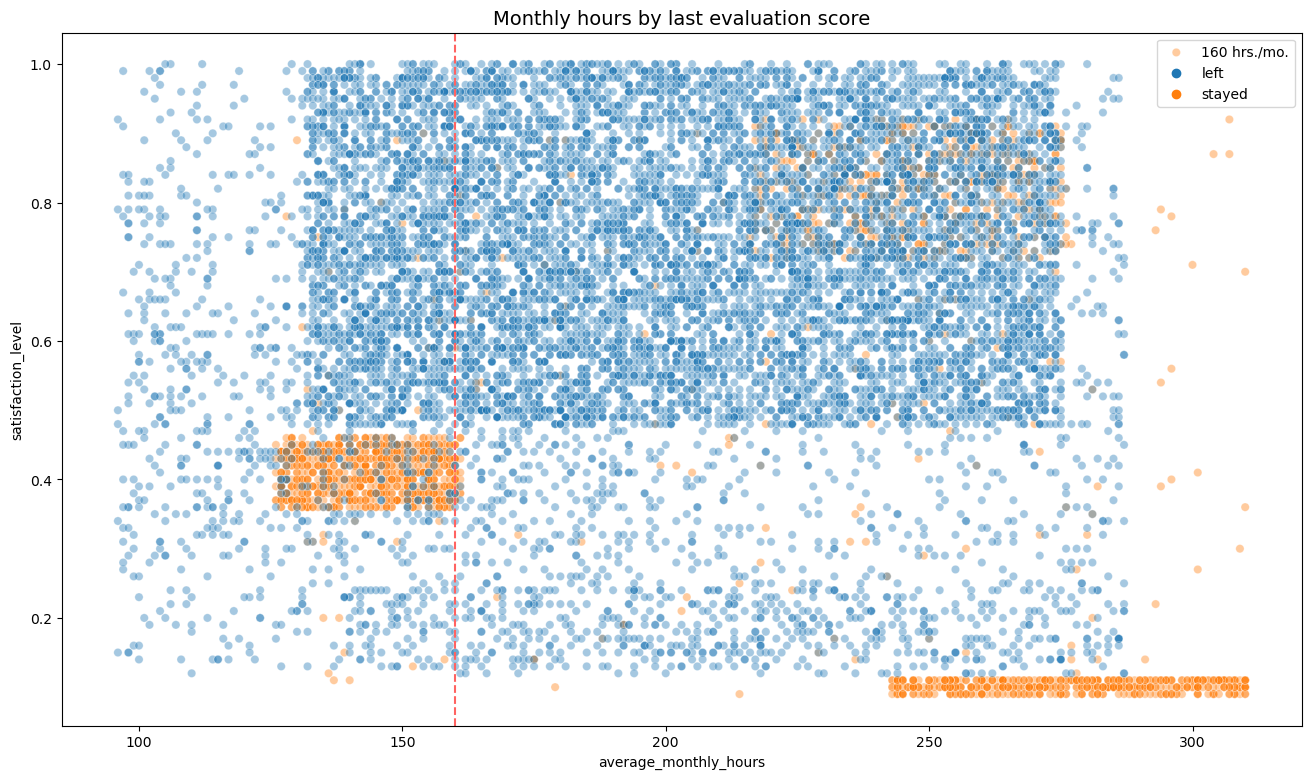

In [487]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=data_1, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=160, color='#ff6361', label='160 hrs./mo.', ls='--')
plt.legend(labels=['160 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

The scatterplot above shows that there was a sizeable group of employees who worked more than 250 hours per month upto 315 hours. 315 hours monthly work is over 75 hours per week for a whole year. It's likely this is related to their satisfaction levels being close to zero.

Let's now visualize the time spend in the company and satisfatction columns and see whether employees feel more satisfied as the number of years they spend in the company increases.

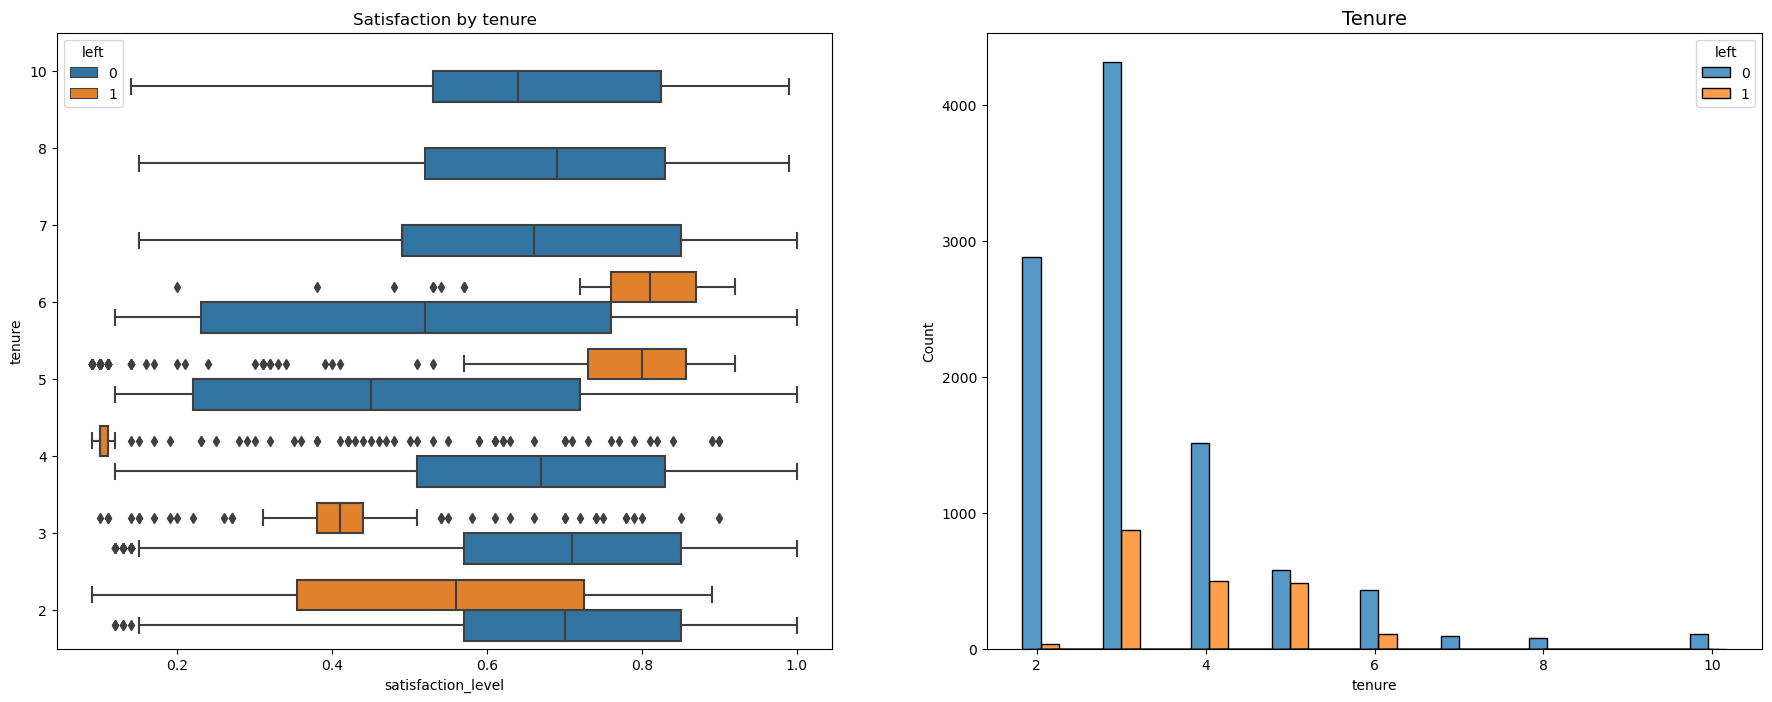

In [486]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Create boxplot showing distributions of `satisfaction_level` by tenure, comparing employees who stayed versus those who left
sns.boxplot(data=data_1, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure')

# Create histogram showing distribution of `tenure`, comparing employees who stayed versus those who left

sns.histplot(data=data_1, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure', fontsize='14')

plt.show();

Employees at their 4 year tenure and those who left seem to have a very low satisfaction level. It's worth investigating what changes to company policy that might have affected people specifically at the four-year mark.

Let's see if there is any relationship between 'left' and 'satisfaction_level' to see whether there was any difference in employees leaving by theier satisfaction in the job?

In [468]:
data_1.groupby(['left'])[['satisfaction_level']].agg([np.median,np.mean])

satisfaction_level          
                 median      mean
left                             
0                  0.69  0.667365
1                  0.41  0.440271

As expected those left the company have a significantly lower satisfaction level compared to those emploees who stayed.

Does last evaluation score of an employee had an effect on them leaving the company?

In order to answer that, we can compare the mean and median values of last evaluation scores of employees for those who left and those stayed.

In [471]:
data_1.groupby(['left'])[['last_evaluation']].agg([np.median,np.mean])

last_evaluation          
              median      mean
left                          
0               0.71  0.715667
1               0.79  0.721783

In [498]:
#sns.boxplot(x='left',y='last_evaluation',data=data_1)

There is no evidence to show that employees leaving has any relationship with their last evaluation score.  Average valuation score of employees were not significantly different between the two employee groups. 

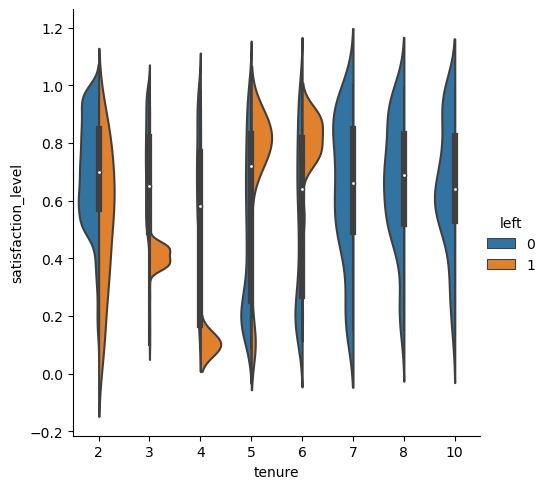

In [482]:
sns.catplot(data=data_1,y='satisfaction_level',x='tenure',hue='left',kind='violin',split=True)

Employees at their 4 year on the job had the lowest satisfaction on the job. There needs to be further investigation on what changes at the company at the 4th year.
New employees and longest serving employees had more or less similar levels of satisfaction on the job.

As shown below, there was significant difference in satisfaction levels between employees who left and employees who stayed in the accounting department.

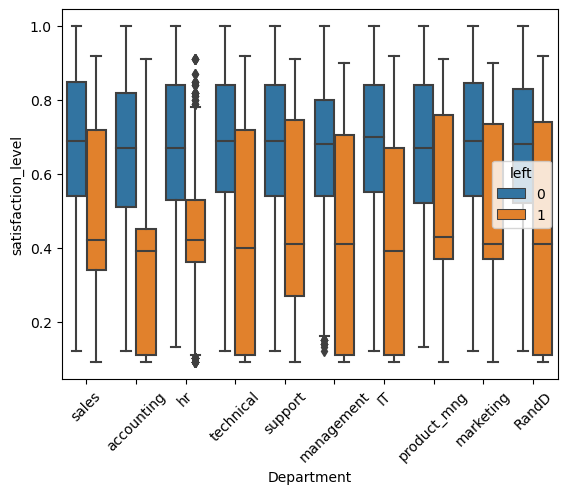

In [504]:
sns.boxplot(data=data_1,y='satisfaction_level',x='Department',hue='left')
plt.xticks(rotation=45)
plt.show();

In [512]:
data_1.groupby(['salary'])[['satisfaction_level']].agg([np.median,np.mean])

satisfaction_level          
                   median      mean
salary                             
high                 0.66  0.637470
low                  0.63  0.600753
medium               0.66  0.621817

There was a slightly lower satisfaction score for employees in the lowest salary scale compared to those in the medium and high salary scale category.

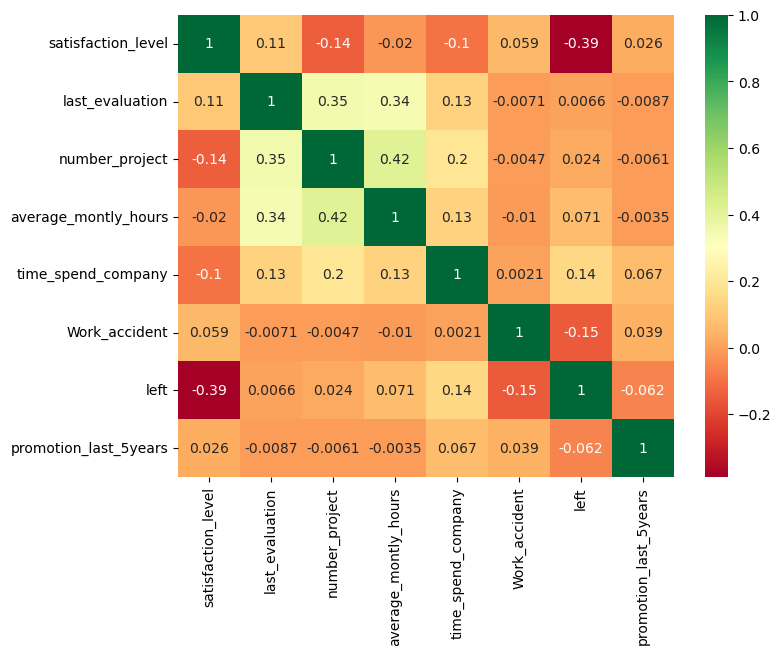

In [516]:
#create a correlationmatrix to see how correlated are each predictors
corrMatrix = data_1.corr()
plt.subplots(figsize=(8,6))
sns.heatmap(corrMatrix, annot=True, cmap="RdYlGn")
plt.show()

#### Observation from visualization

The correlation heatmap confirms that the number of projects, monthly hours, and evaluation scores all have some positive correlation with each other, and whether an employee leaves is negatively correlated with their satisfaction level.Leaving is tied to longer working hours, many projects, and generally lower satisfaction levels. It can be ungratifying to work long hours and not receive promotions or good evaluation scores. There's a sizeable group of employees at this company who are probably burned out.

## Model Building

The goal of the project is to build a model that predicts whether employees leave the company. It is a classification problem and Logistic regression model or tree based models such as random forest, decision tree or XGBOOST models can be used.

### A. Logistic Regression

In order to use logistic regression models, certain assumptions have to be met with the data we have. These assumptions are:


- The outcome variable should be binary
- Linear relationship between each predictors and logit of the response variable
- No multicollinearity between our predictors
- No extreme outliers
- The observations in the dataset are independent of each other
- large sample size 


The predicted outcome is whether employees leave, which is binary where the number of outcomes is two.

In [89]:
print(data_1['left'].nunique())

2


Since we have close to 15000 observations which is sufficiently large enough to fulfill the final assumptions to use logistic regression models.
We also will have to remove extreme outliers.


No multicollinearity between our predictors can be checked either using correlation matrix or variance inflation factor(VIF). We have already checked above there is some degree of collinearity among few variables. However it is not strong enough to remove features from model building.

Removing outliers so that these values do not affect our logistic regression model assumption

In [90]:
percentile_25=data_1['tenure'].quantile(0.25)
percentile_75=data_1['tenure'].quantile(0.75)
IQR=percentile_75-percentile_25

lower_threshold=percentile_25-1.5*IQR
upper_threshold=percentile_75+1.5*IQR

outliers_tenure=data_1[(data_1['tenure'] < lower_threshold)| (data_1['tenure'] > upper_threshold)]
len(outliers_tenure)

824

In order to use Logistic regression model, we need to deal with the outliers. For the purpose of this project, we will remove the outliers from the data and save the resulting dataframe as 'log_data'.

In [91]:
log_data=data_1.drop(outliers_tenure.index)

In [92]:
log_data.shape

(11167, 10)

Let's confirm if the outliers have been removed

In [505]:
#sns.boxplot(log_data['tenure'])

From the heatmap above, we can see there is some degree of correlation among few predictors. However, since the correlation is not strong enough, we will keep all the variables for now.

#### Data Pre-processing

Most machine learning algorithms can not work with categorical data. We need to transform the categorical columns in the dataset to numeric so that we can ake it ready for modeling.
The two categorical columns are 'department' and 'salary'.

In [242]:
log_data['department'].value_counts()

sales          2997
technical      2114
support        1721
IT              915
RandD           649
product_mng     641
marketing       617
accounting      583
hr              570
management      360
Name: department, dtype: int64

Since the salary column is ordered, it is an ordinal categorical variable. There is hierarchy to the categories. There is no need to dummy code the variable rather assign values 0-2.

In [ ]:
log_data['salary'].value_counts()

In [95]:
log_data_encoded=log_data.copy()

In [96]:
log_data_encoded['salary'] = (
    log_data_encoded['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

In [97]:
log_data_encoded['salary'].value_counts()

0    5429
1    4854
2     884
Name: salary, dtype: int64

The department column however need to be dummy coded in order to change it to numeric.

In [98]:
log_data_final=pd.get_dummies(log_data_encoded,drop_first=True)

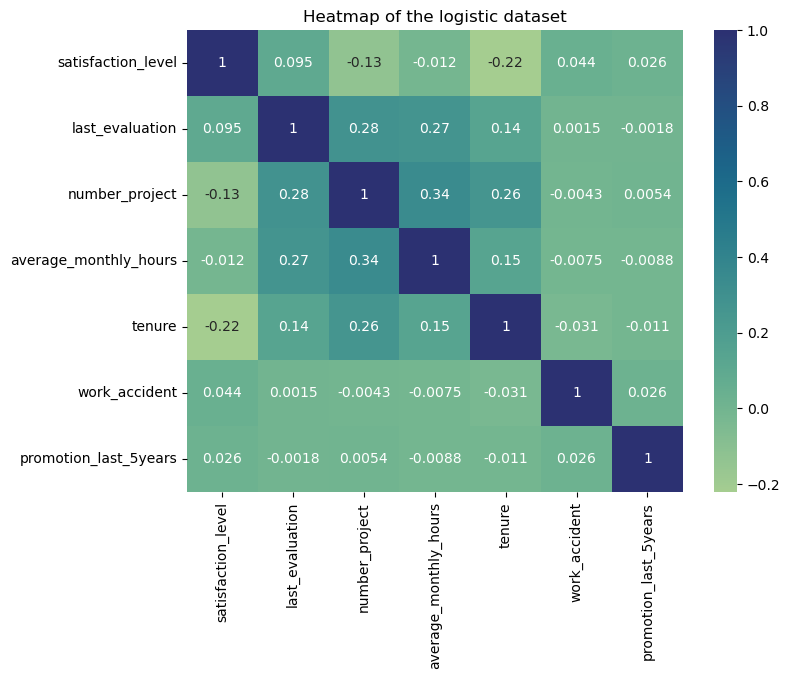

In [99]:
plt.figure(figsize=(8, 6))
sns.heatmap(log_data_final[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure','work_accident','promotion_last_5years']].corr()
                                ,annot=True,cmap='crest')
plt.title('Heatmap of the logistic dataset')
plt.show()

In [100]:
log_data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

#### Split the data in to training and testing data

In [101]:
X=log_data_final.copy()

In [102]:
X=X.drop(['left'],axis=1)

In [ ]:
X.head()

In [103]:
y=log_data_final['left']

In [104]:
log_data_final['left'].value_counts(normalize=True)

0    0.831468
1    0.168532
Name: left, dtype: float64

We have an inblanced data. When we split the data in to trainning and testing, we can get unlucky and most of the employees who left could end up  in the trainning dataset and not the test dataset. In order to cancel this class imbalance in the dataset, we could use 'stratify=y'

In [105]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,stratify=y,random_state=42)

We build a logistic refression classifier model and fit it on the trainning data

In [119]:
log_model=LogisticRegression(max_iter=500).fit(X_train,y_train)

In [120]:
log_model.coef_

array([[-4.32638471e+00, -1.30826010e-02, -4.86015717e-01,
         3.57160703e-03,  1.10036201e+00, -1.50624097e+00,
        -9.81118568e-01, -5.26786451e-01, -2.37294334e-01,
        -1.85403318e-01,  2.87878907e-02, -1.22783366e-01,
        -4.91235455e-02, -5.28472496e-02,  8.98480027e-02,
         1.03852428e-01,  8.58337167e-02]])

In [ ]:
log_model.intercept_

Test the logistic regression model. Use the logistic regression model to get predictions on the test dataset

In [110]:
y_pred=log_model.predict(X_test)

In [526]:
y_pred[:20]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [111]:
log_model.predict_proba(X_test)

array([[0.97778363, 0.02221637],
       [0.96062429, 0.03937571],
       [0.95097697, 0.04902303],
       ...,
       [0.81853498, 0.18146502],
       [0.96247347, 0.03752653],
       [0.60586639, 0.39413361]])

Use Confusion matrix to visualize the results of the logistic regression model. 

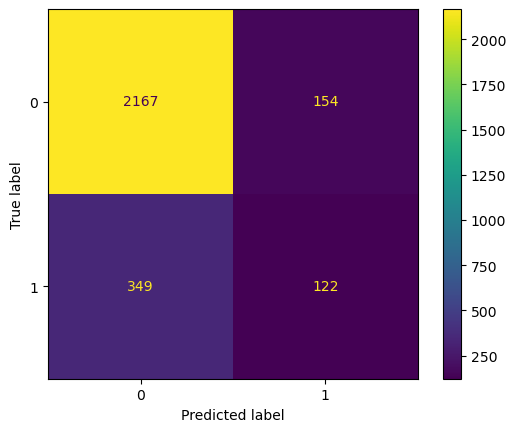

In [113]:
log_cm=confusion_matrix(y_test,y_pred,labels=log_model.classes_)

log_model_disp=ConfusionMatrixDisplay(log_cm,display_labels=log_model.classes_)

log_model_disp.plot(values_format='')
plt.show()

Create classification report for logistic regression model

In [121]:
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.44      0.26      0.33       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.60      0.61      2792
             weighted avg       0.79      0.82      0.80      2792



The classification report above shows that the logistic regression model above had a precision of 79%, recall of 82%, f1-score of 80%, AUC score of 59%. However, if it's most important to predict employees who leave, then the scores are significantly lower as shown below.

In [122]:
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_test, y_pred))
print("Precision:", "%.6f" % metrics.precision_score(y_test, y_pred))
print("Recall:", "%.6f" % metrics.recall_score(y_test, y_pred))
print("F1 Score:", "%.6f" % metrics.f1_score(y_test, y_pred))
print("AUC Score:", "%.6f" % metrics.roc_auc_score(y_test, y_pred))

Accuracy: 0.819842
Precision: 0.442029
Recall: 0.259023
F1 Score: 0.326640
AUC Score: 0.596336


Accuracy is a very good metric to use for balanced data but AUC is well-suited to measure the model’s performance on an imbalanced set. Since we have an inbalanced data, we will be using AUC SCORE to measure the model performance.

### B. Decision Tree

Most machine learning algorithms can not work with categorical data. We need to transform the categorical columns in the dataset to numeric so that we can ake it ready for modeling. The two categorical columns are 'department' and 'salary'.

In [342]:
tree_data=data_1.copy()

In [343]:
tree_data['salary'].value_counts()

low       5740
medium    5261
high       990
Name: salary, dtype: int64

In [344]:
tree_data['department'].value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: department, dtype: int64

We need to transform categorical columns to numeric ones as we did in the previous section with logistic data

In [345]:
tree_data_encoded=tree_data.copy()

In [346]:
tree_data_encoded['salary'] = (
    tree_data_encoded['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

In [347]:
tree_data_encoded['salary'].value_counts()

0    5740
1    5261
2     990
Name: salary, dtype: int64

In [348]:
tree_data_final=pd.get_dummies(tree_data_encoded,drop_first=True)

In [349]:
tree_data_final.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,1,0,0


Split the data in to trainning and testing

In [350]:
X=tree_data_final.copy()

In [351]:
X=X.drop('left',axis=1)

In [352]:
y=tree_data_final['left']

In [353]:
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,1,0,0


In [354]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

Construct a decision tree model and set up cross-validated grid-search to exhuastively search for the best model parameters.

Accuracy is a very good metric to use for balanced data but AUC is well-suited to measure the model’s performance on an imbalanced set. Since we have an inbalanced data, we will be using AUC SCORE to measure the model performance.

In [433]:
# Instantiate model
clf = DecisionTreeClassifier(random_state=42)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, None],
             'min_samples_leaf': [4, 6],
             'min_samples_split': [4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1','roc_auc']

# Instantiate GridSearch
dt = GridSearchCV(clf, cv_params, scoring=scoring,cv=4,  refit='roc_auc')

Fit the decision tree model

In [434]:
%%time
dt.fit(X_train, y_train)

CPU times: user 1.46 s, sys: 32.3 ms, total: 1.5 s
Wall time: 1.51 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 6, None], 'min_samples_leaf': [4, 6],
                         'min_samples_split': [4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [435]:
dt.best_score_

0.9698667651120891

In [436]:
dt.best_params_

{'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 4}

In [457]:
dt.best_estimator_

DecisionTreeClassifier(max_depth=4, min_samples_leaf=6, min_samples_split=4,
                       random_state=42)

#### C.Randdom Forest

Construct a random forest model and set up cross-validated grid-search to exhuastively search for the best model parameters.

In [203]:
# 1. Instantiate the random forest classifier
rfclf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1','roc_auc']

# 4. Instantiate the GridSearchCV object
rf = GridSearchCV(rfclf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fit the random forest model to the training data.

In [204]:
%%time
rf.fit(X_train, y_train)

CPU times: user 28min 49s, sys: 17.4 s, total: 29min 7s
Wall time: 32min 58s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [205]:
# Define a path to the folder to save the model so that we don't have to run at again as it can take from 30-60 minutes
path = '/Users/yonastena/Downloads/Google DA'

In [206]:
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)


In [207]:
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model


In [208]:
# Write pickle
write_pickle(path, rf, 'hr_rf')

In [211]:
#read pickle
read_pickle(path, 'hr_rf')

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [374]:
#check the best score roc_auc in this case and compare it with the dt
rf.best_score_

0.9800747325008482

In [376]:
# Check best params
rf.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

compare the results of the decision tree and random forest by extracting from the gridsearch using table format.In order to do that lets create a function that lists the results of the two models 

In [214]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [222]:
dt_result = make_results('decision tree', dt, 'auc')
dt_result

,model,precision,recall,F1,accuracy,auc
0,decision tree,0.914552,0.916949,0.915707,0.971978,0.969819


In [223]:
rf_result=make_results('random_forest',rf,'auc')
rf_result

,model,precision,recall,F1,accuracy,auc
0,random_forest,0.94922,0.912933,0.930703,0.977427,0.980075


In [225]:
results=pd.concat([dt_result,rf_result],axis=0)
results

,model,precision,recall,F1,accuracy,auc
0,decision tree,0.914552,0.916949,0.915707,0.971978,0.969819
0,random_forest,0.949220,0.912933,0.930703,0.977427,0.980075


The above table shows evaluation scores on the training dataset for both the decision tree and random forest models.
From the table we can see random forest model performs better than the decision tree model in all the metric except 'recall'

Next step is to evaluate the best random forest model on the test set.

Next step is to evaluate the best random forest model on the test set. In order to do that we need to define a function that gets all the scores from a model's predictions.

In [232]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                         })
  
    return table

In [233]:
# Get predictions on test data
rf_test_score = get_scores('random forest test', rf, X_test, y_test)
rf_test_score

,model,precision,recall,F1,accuracy,auc
0,random forest test,0.966173,0.917671,0.941298,0.980987,0.955635


In [234]:
#final result
final_result = pd.concat([results, rf_test_score], axis=0)
final_result

,model,precision,recall,F1,accuracy,auc
0,decision tree,0.914552,0.916949,0.915707,0.971978,0.969819
0,random_forest,0.949220,0.912933,0.930703,0.977427,0.980075
0,random forest test,0.966173,0.917671,0.941298,0.980987,0.955635


The model performance on the test set is very similar to its performance on the trainning set, which can give us an assurance that it can perform fairly good on unseen data. We can also see the model performance using a confusion matrix.

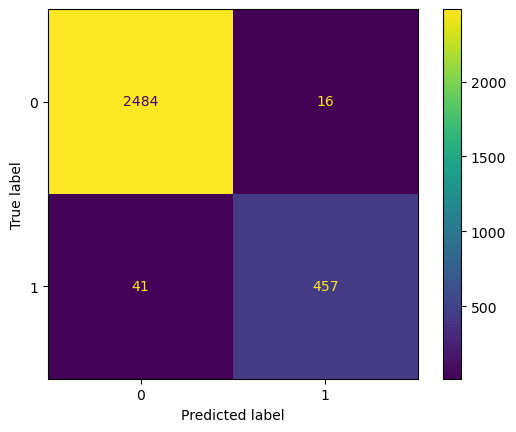

In [424]:
# Generate array of values for confusion matrix
pred = rf.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, pred, labels=rf.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf.classes_)
disp.plot(values_format='');

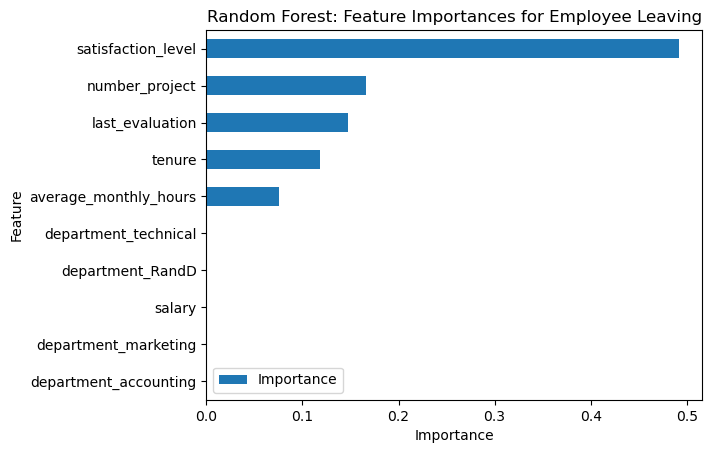

In [453]:
# Get feature importances
feat_impt = rf.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

###### Bonus: plotting decision trees feature importance
Now we need to inspect the splits of the decision tree model and the most important features in the random forest model to see the explanatory power of the model.
The best parameters we get using hyperparameter tuning was very complex and difficult to interpret. Instead let's use the max_depth parameter and leave the other vest parameters of the classifier. The purpose here is to show how to plot the decision tree feature importance.

In [449]:
treeclf = DecisionTreeClassifier(random_state=42, max_depth=4)
treeclf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

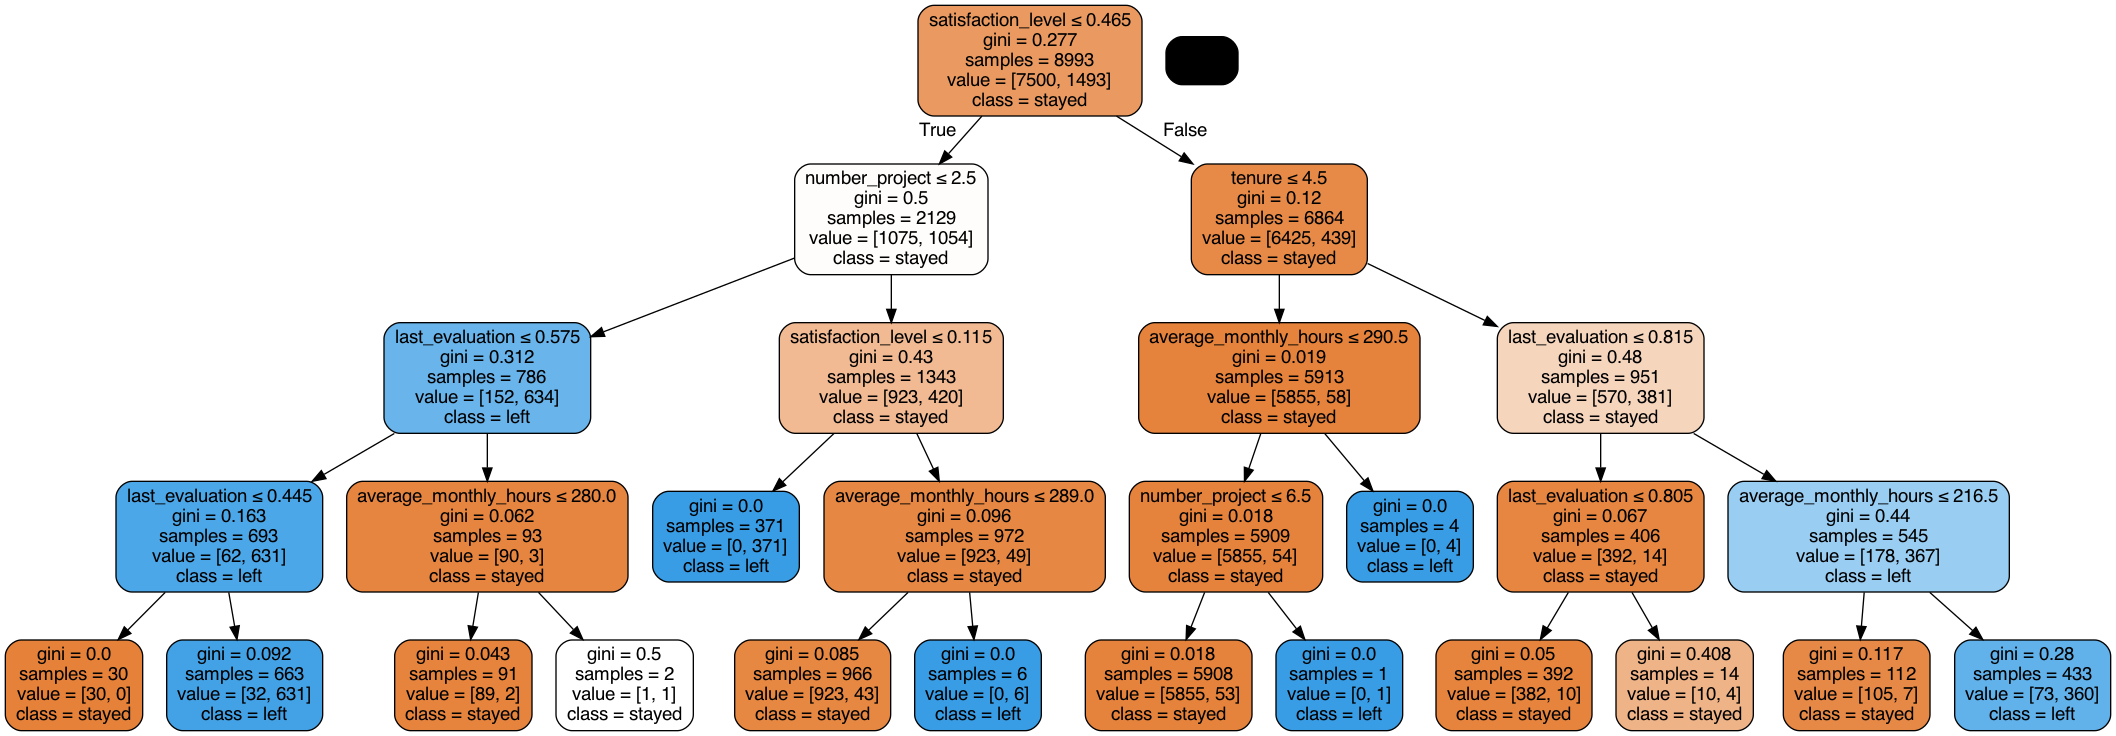

In [450]:
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(treeclf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X.columns,class_names=['stayed','left'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('hr.png')
Image(graph.create_png())

In [483]:
#treeclf.fit(X_test,y_test).feature_importances_

In [444]:
dftree=pd.DataFrame({'Feature_names':X.columns,'Importances':treeclf.fit(X_test,y_test).feature_importances_})

In [464]:
dftree=dftree.sort_values(by='Importances',ascending=False)

In [507]:
dftree[:6]

,Feature_names,Importances
0,satisfaction_level,0.507847
2,number_project,0.143703
1,last_evaluation,0.136295
4,tenure,0.130526
3,average_monthly_hours,0.081629
11,department_management,0.000000


In [460]:
#sns.barplot(data=dftree,x='Importances',y='Feature_names',orient='h')

<Axes: xlabel='Importances', ylabel='Feature_names'>

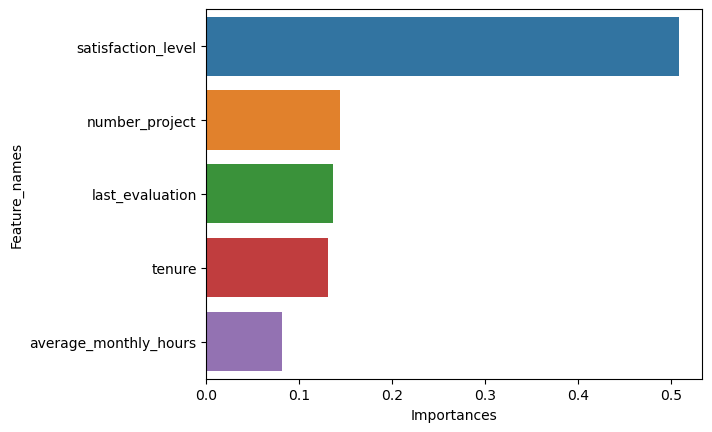

In [456]:
#since we have many 0 values in the 'Importances' column, let's remove these values
dfdt=dftree[dftree['Importances']!=0]
dfdt
sns.barplot(data=dfdt,x='Importances',y='Feature_names',orient='h')

The feature importance plot of both the best random forest model as well as the decision tree model shows that **satisfaction_level, last_evaluation, tenure, and  average_monthly_hours** have the highest importance, in that order. These variables are most helpful in predicting the dependent variable, **left**.

## Conclusion

We can see from the initial data analysis and the model, employees leaving the company is closely tied to longer working hours, many projects, and lower satisfaction levels.In order to retain more employees, the company need to seriously consider about reducing the number of projects an employee work on a month.

The longest serving employees didn't leave the company. Employees at their 4 year on the job had the lowest satisfaction on the job. There needs to be further investigation on what changes at the company at the 4th year.
Extremely large amount of monthly woking hours can be related to employees' satisfaction levels being close to zero. The company shpould not require employees to work long hours or if they do compensate or reward them for working long hours.

**satisfaction_level, last_evaluation, tenure, and average_monthly_hours**  are the most helpful features in predicting whether an employee will leave the company.